In [29]:
import sys
sys.path.append("/opt/ml/code/")

In [30]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

import re
import math

import model_encoder

# 데이터 로딩

In [2]:
df = pd.read_json('../../data/wikipedia_documents.json').T

## 중복 데이터 제거

In [4]:
df = df.drop_duplicates(subset=['text'])
df.nunique()

text             56737
corpus_source        1
url                  1
domain               0
title            31726
author               0
html                 0
document_id      56737
dtype: int64

## 데이터 길이 분포 분석

In [5]:
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

In [7]:
def tokenized_len(row):
  return len(tokenizer.tokenize(row))

In [8]:
df['tokenizedCount'] = df['text'].apply(tokenized_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1131 > 512). Running this sequence through the model will result in indexing errors


<AxesSubplot:xlabel='tokenizedCount', ylabel='Count'>

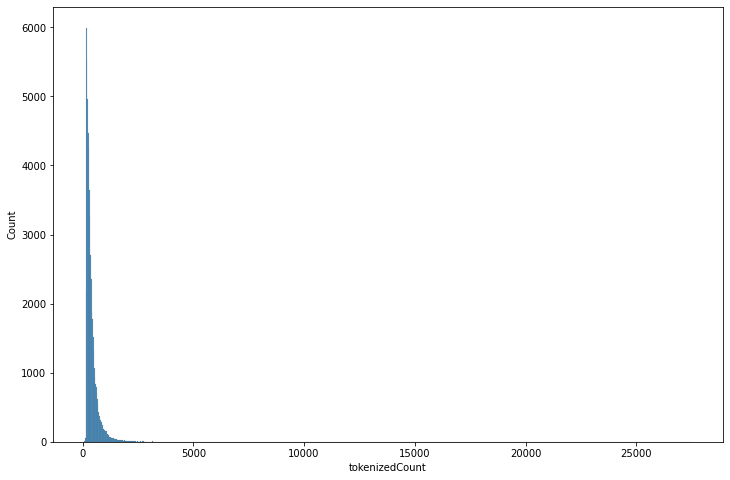

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(x='tokenizedCount', data=df, bins=1000)

In [10]:
df['tokenizedCount'].describe()

count    56737.000000
mean       401.889208
std        392.152975
min         54.000000
25%        221.000000
50%        308.000000
75%        457.000000
max      27539.000000
Name: tokenizedCount, dtype: float64

# 위키데이터 쪼개기

In [12]:
splited_documents = []
count = 0
for index, document in tqdm(df.iterrows()):
  # print("==================count=====================",count)
  
  original_passage = document['text']

  length_of_tokenized_text = len(tokenizer.tokenize(original_passage))

  number_of_passages_to_create = math.ceil(length_of_tokenized_text / 400)  # 510으로 안하는 이유는 110만큼의 buffer를 주기 위해서
  min_required_length = length_of_tokenized_text // number_of_passages_to_create  # 최소 길이
  max_possible_length = min_required_length + 110  # 최대길이

  end_of_sentences = re.findall(r'[가-힣]+\S*\.', original_passage)
  sentences = re.split(r'[가-힣]+\S*\.', original_passage)
  sentence_counter = 0


  # print(min_required_length)
  for i in range(number_of_passages_to_create):
    partial_text = ''
    partial_text_length = 0

    if sentence_counter == len(end_of_sentences)-1:
      break
    
    for j in range(len(sentences) - 1):
      partial_text += sentences[sentence_counter] + end_of_sentences[sentence_counter]
      partial_text_length += len(tokenizer.tokenize(sentences[sentence_counter] + end_of_sentences[sentence_counter]))
      # print('==============================', sentence_counter, len(sentences)-1, len(end_of_sentences)-1)
      # print(partial_text, partial_text_length)
      sentence_counter += 1
      if partial_text_length >= min_required_length or sentence_counter == len(end_of_sentences)-1:
        
        if sentence_counter == len(end_of_sentences)-1:
          partial_text += sentences[-1]
        document_to_be_added = {
          'text': partial_text,
          'title': document['title'],
          'document_id': count # document['document_id']
        }

        splited_documents.append(document_to_be_added)
        count +=1
        break
print("length of data after split: ", len(splited_documents))

56737it [03:16, 289.35it/s]


## 엘라스틱서치 연결

In [16]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])
es.ping()

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


True

### 인덱스 목록 보기

In [17]:
res = es.indices.get_alias("*")
for Name in res:
  print(Name)

.kibana_task_manager_7.15.1_001
.apm-agent-configuration
.kibana-event-log-7.15.1-000001
.apm-custom-link
wiki_documents_splited_dense
.kibana_7.15.1_001
wiki_documents_dense
wiki_documents_splited
wiki_documents
.tasks


/tmp/ipykernel_2540/3052314421.py:1: DeprecationWarning: Using positional arguments for APIs is deprecated and will be disabled in 8.0.0. Instead use only keyword arguments for all APIs. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.indices.get_alias("*")
/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: this request accesses system indices: [.kibana_task_manager_7.15.1_001, .apm-agent-configuration, .apm-custom-link, .kibana_7.15.1_001, .tasks], but in a future major version, direct access to system indices will be prevented by default
  warnings.warn(message, category=ElasticsearchWarning)


### 인덱스 삭제하기

In [ ]:
# es.indices.delete(index='wiki_documents_splited', ignore=[400, 404])

## 쪼깨진 위키데이터 입력

### 쪼갠 위키데이터를 입력하기 위한 제너레이터

In [ ]:
def generator(splited_documents):
  for c, line in enumerate(splited_documents):
    yield {
      '_index': 'wiki_documents_splited',
      '_type': '_doc',
      '_id': line.get('document_id', None),
      '_source': {
        'title': line.get('title', ''),
        'text': line.get('text', '')
      }
    }
  raise StopIteration

In [ ]:
CONFIG = {
  'settings':{
    'number_of_shards':1,
    'number_of_replicas':1,
    'analysis':{
      'analyzer': {
        'nori_analyzer':{
          'type': 'custom',
          'tokenizer': 'nori_tokenizer'
        }
      },
    }
  },
  'mappings':{
    'properties':{
      'title':{
        'type':'text'
      },
      'text':{
        'type':'text',
        "analyzer": "nori_analyzer"
      }
    }
  }
}

In [ ]:
es.indices.create(index='wiki_documents_splited', ignore=[400,404], body=CONFIG)

In [ ]:
gen = generator(splited_documents)
try:
  res = helpers.bulk(es, gen, chunk_size = 1)
  # print(res)
except Exception as e:
  print(e)
  print('Done')

# 쪼갠 위키데이터 Dense Embedding해서 넣기

In [62]:
p_encoder = model_encoder.BertEncoder.from_pretrained('../encoders/p_encoder_neg').to('cuda')

In [63]:
p_embs = []
for document in tqdm(splited_documents):
  with torch.no_grad():
    p_encoder.eval()
    p_val = tokenizer([document['text']], padding="max_length", truncation=True, return_tensors='pt', max_length=510).to('cuda')

    p_emb = p_encoder(**p_val)
    p_embs.append(p_emb[0].cpu().detach().numpy().tolist())
    

100%|██████████| 78411/78411 [20:55<00:00, 62.45it/s]


In [64]:
CONFIG = {
  'settings':{
    'number_of_shards':1,
    'number_of_replicas':1,
    'analysis':{
      'analyzer': {
        'nori_analyzer':{
          'type': 'custom',
          'tokenizer': 'nori_tokenizer'
        }
      },
    }
  },
  'mappings':{
    'properties':{
      'text':{
        'type':'text',
        "analyzer": "nori_analyzer"
      },
      'vector':{
        'type':'dense_vector',
        'dims':768
      }
    }
  }
}

In [65]:
es.indices.delete(index='wiki_documents_splited_dense', ignore=[400, 404])
es.indices.create(index='wiki_documents_splited_dense', ignore=[400,404], body=CONFIG)

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/tmp/ipykernel_2540/2407913785.py:2: DeprecationWarning: The 'body' parameter is deprecated for the 'create' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.indices.create(index='wiki_documents_splited_dense', ignore=[400,404], body=CONFIG)


{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'wiki_documents_splited_dense'}

In [66]:
def generator(splited_documents, p_embs):
  for document, vector in zip(splited_documents, p_embs):
    yield {
      '_index': 'wiki_documents_splited_dense',
      '_type': '_doc',
      '_id': document.get('document_id', None),
      '_source': {
        'text': document.get('text', ''),
        'vector': vector
      }
    }
  raise StopIteration

In [67]:
gen = generator(splited_documents, p_embs)
try:
  res = helpers.bulk(es, gen, chunk_size = 1)
  # print(res)
except Exception as e:
  print(e)
  print('Done')

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchWarning)


generator raised StopIteration
Done


## 검증해보기

In [74]:
q_encoder = model_encoder.BertEncoder.from_pretrained('../encoders/q_encoder_neg').to('cuda')

In [94]:
with torch.no_grad():
  q_encoder.eval()
  q_val = tokenizer(['대한민국의 수도는 어느 도시인가요?'], padding="max_length", truncation=True, return_tensors='pt', max_length = 510).to('cuda')

  q_emb = q_encoder(**q_val)
  q_output = q_emb[0].cpu().detach().numpy().tolist()

In [95]:
res = es.search(
  index='wiki_documents_splited_dense',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match_all" : {}
        },
        "script": {
          # "source": "1 / (1 + l2norm(params.queryVector, doc['vector']))",
          "source": "cosineSimilarity(params.queryVector, doc['vector']) + 1.0",
          "params": {
            "queryVector": q_output
          }
        }
      }
    }
  },
  size= 10
)

/tmp/ipykernel_2540/2670386276.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [96]:
for i in range(10):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

" 라고 함으로써 허락되지 않았다.
”라고 하여 ‘호해정-호해지사-호걸지사-호연지기’로까지 논리를 확장시켰다.
 이다]."p=61."
지나친 가정상 왜곡이   제기됐다.
 그 외에 정실을 알고도 자수하지 않은 자들은 모두 다 용서한다.
간혹 가상방송사도 있다.
정확히 4260개의 10진법 왼편 절단 가능 소수가 있다.
 탐ㆍ진ㆍ치에 의지하는 것으로 말미암는 까닭이다. 올바른 이치에 의지하지 않고 여러 모양에 집착하거나 그 좋아하는 것에 집착하는 것이다."
종아리뼈는 다음과 같이 나눌 수 있다.
방방지는 지역과 상표나 장사한 사람의 이름에 따라 다양하게 불린다.


# 쪼개지 않은 문서 임베딩 해서 넣기

In [68]:
text = df['text'].to_list()
title = df['title'].to_list()
document_id = df['document_id'].to_list()

In [69]:
p_embs_not_splited = []
for index, document in tqdm(df.iterrows()):
  with torch.no_grad():
    p_encoder.eval()
    p_val = tokenizer([document['text']], padding="max_length", truncation=True, return_tensors='pt', max_length=510).to('cuda')

    p_emb = p_encoder(**p_val)
    p_embs_not_splited.append(p_emb[0].cpu().detach().numpy().tolist())

56737it [15:44, 60.05it/s]


In [70]:
CONFIG = {
  'settings':{
    'number_of_shards':1,
    'number_of_replicas':1,
    'analysis':{
      'analyzer': {
        'nori_analyzer':{
          'type': 'custom',
          'tokenizer': 'nori_tokenizer'
        }
      },
    }
  },
  'mappings':{
    'properties':{
      'text':{
        'type':'text',
        "analyzer": "nori_analyzer"
      },
      'vector':{
        'type':'dense_vector',
        'dims':768
      }
    }
  }
}

In [71]:
es.indices.delete(index='wiki_documents_dense', ignore=[400, 404])
es.indices.create(index='wiki_documents_dense', ignore=[400,404], body=CONFIG)

/tmp/ipykernel_2540/2952044086.py:2: DeprecationWarning: The 'body' parameter is deprecated for the 'create' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.indices.create(index='wiki_documents_dense', ignore=[400,404], body=CONFIG)


{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'wiki_documents_dense'}

In [72]:
def generator(text, title, document_id, p_embs_not_splited):
  for text_el, title_el, document_id_el, p_embs_el in zip(text,title,document_id, p_embs_not_splited):
    yield {
      '_index': 'wiki_documents_dense',
      '_type': '_doc',
      '_id': document_id_el,
      '_source': {
        'text': text_el,
        'vector': p_embs_el
      }
    }
  raise StopIteration

In [73]:
gen = generator(text, title, document_id, p_embs_not_splited)
try:
  res = helpers.bulk(es, gen, chunk_size = 1)
  # print(res)
except Exception as e:
  print(e)
  print('Done')

generator raised StopIteration
Done


## 검증해보기

In [81]:
q_encoder = model_encoder.BertEncoder.from_pretrained('../encoders/q_encoder_neg').to('cuda')

In [186]:
query = '한 무제가 정복한 나라는?'
with torch.no_grad():
  q_encoder.eval()
  q_val = tokenizer([query], padding="max_length", truncation=True, return_tensors='pt', max_length = 510).to('cuda')

  q_emb = q_encoder(**q_val)
  q_output = q_emb[0].cpu().detach().numpy().tolist()

In [187]:
res = es.search(
  index='wiki_documents_dense',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match" : {
            "text": query
          }
        },
        "script": {
          # "source": "1 / (1 + l2norm(params.queryVector, doc['vector']))",
          # "source": "cosineSimilarity(params.queryVector, doc['vector']) + 1.0",
          # "source": "_score + cosineSimilarity(params.queryVector, doc['vector'])",
          "source": "_score * cosineSimilarity(params.queryVector, doc['vector']) / (_score + cosineSimilarity(params.queryVector, doc['vector'])) + cosineSimilarity(params.queryVector, doc['vector']) * _score / (_score + cosineSimilarity(params.queryVector, doc['vector']))",
          "params": {
            "queryVector": q_output
          }
        }
      }
    }
  },
  size= 3
)

/tmp/ipykernel_2540/4002000892.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [188]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

남제 말기에 황제였던 동혼후는 폭정을 해 많은 대신들을 살해했고 먼 친척인 소의를 살해했다. 옹주자사로 양양에 있던 소의의 동생인 소연은 폭군을 처단한다는 명분으로 군사를 일으켜 건강을 함락한 뒤 동혼후를 살해한 뒤 화제를 옹립했다. 502년에 소연은 화제로부터 제위를 선양받아 양나라를 건국하니 그가 바로 무제이다.\n\n무제의 치세는 48년이란 긴 기간이었고, 그동안 내정을 정비하여 구품관인법을 개선했고 불교를 장려하여 국내를 안정시켰으며 문화를 번영시켰다. 대외관계도 비교적 평온하여 약 50년간 태평성대를 유지하여 남조 최전성기를 보냈다. 또한 무제의 맏아들인 소명태자가 편찬한 《문선》은 후세에까지 전해지는 훌륭한 문헌이다.\n\n그러나 무제의 50년에 걸친 치세 후반에는 불교에 너무 심취하여 스스로 동태사(同太寺)에 여러 번 사신(捨身)을 행하는 무모한 짓을 여러 번 일으켰다. 그럴 때마다 신하들은 막대한 돈을 들여 무제를 되찾아 왔기에 국고가 크게 궁핍해졌다. 퇴위 후 법황의 신분이라면 모르나 재임 도중에 황제를 잃는 일은 없었기 때문에 이런 황당한 일이 벌어진 것이었다.\n\n548년 동위의 무장이었던 후경이 투항해 왔다가 반란을 일으켜 수도인 건강으로 진격했다. 다음해 건강이 함락됐고 무제는 사로잡힌 뒤 쇠약해져 죽었다. 각지에 분봉되었던 종실의 여러 왕들은 형제나 삼촌, 조카들이었기에 서로의 이득을 보고 견제를 한 결과 모두 황제의 구출에 나서지않아 무제가 죽는 걸 보고만 있었다. 후경은 간문제를 옹립했다가 551년에 간문제를 살해하고 예장왕 소동을 제위에 올린 뒤 선양을 받아 황제에 올라 건강에서 즉위했다. 각지에 주둔한 여러 왕들 중 가장 세력이 강했던 형주자사 소역은 왕승변에게 대군을 주어 건강을 공격해 후경을 죽였다.\n\n소역은 즉위한 뒤 황폐화된 건강을 버리고 강릉으로 수도를 옮기니 그가 바로 원제이다. 그러나 이 혼란을 틈타 남정에 나선 서위는 촉(蜀)에 있던 무릉왕 소기와 원제의 대립을 틈타 촉을 점령했다. 또한 양양을 가지고 투항해

In [189]:
res = es.search(
  index='wiki_documents_dense',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match" : {
            "text": query
          }
        },
        "script": {
          # "source": "1 / (1 + l2norm(params.queryVector, doc['vector']))",
          "source": "cosineSimilarity(params.queryVector, doc['vector']) + 1.0",
          # "source": "_score + cosineSimilarity(params.queryVector, doc['vector'])",
          # "source": "_score * cosineSimilarity(params.queryVector, doc['vector']) / (_score + cosineSimilarity(params.queryVector, doc['vector'])) + cosineSimilarity(params.queryVector, doc['vector']) * _score / (_score + cosineSimilarity(params.queryVector, doc['vector']))",
          "params": {
            "queryVector": q_output
          }
        }
      }
    }
  },
  size= 3
)

/tmp/ipykernel_2540/1804198656.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [190]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

서초왕 항우를 멸망시키고 중국을 재통일한 황제 유방(유방)은 흉노에 대비하기 위해 한왕 신을 대(代) 땅으로 파견했지만, 한왕 신은 흉노와의 평화를 주장했다. 이를 배신으로 간주하자 한왕 신은 흉노에 투항했고, 한왕의 군대가 더해진 흉노 4만 대군이 태원(太源)으로 쏟아져 들어왔다.\n\n고조는 32만 군대를 거느리고 평성(平城)에서 흉노를 요격하였다. 하지만 고조의 본대는 약병으로 가장한 흉노의 위장 퇴각에 속아 진격하다가 고립되어 백등산에서 포위되었다. 이때 흉노군은 북방 군단은 흑마, 남방 군단은 적마, 서방 군단은 백마, 동방 군단은 흰 얼굴의 흑마에 타고 한군을 포위하고 있었다.\n\n7일간 포위된 고조는 진평의 건의에 따라 묵돌 선우의 아내에게 뇌물을 주어 포위의 일각을 벌렸고, 그곳을 통해 포위를 벗어나 간신히 장안으로 도망칠 수 있었다. 이때 한군 병사들은 열 명에 세 명 꼴로 동상으로 손가락이 떨어져 나갔다.\n\n이후 고조는 흉노에 공물을 주겠다는 조건으로 형제 관계의 화친을 맺었다. 이 관계는 한무제 때까지 이어졌다.
현재는 천자가 황제와 사실상 똑같은 호칭이고 실제로 황제가 곧 천자로 간주되는 기간이 길었지만 황제는 진시황이 새로 만든 지위고 중국 역사상 한족이 그들의 군주를 천자로 부른 것은 상당히 오래된 일인데, 기록에는 기원전 1000년 경에 이미 주(周)의 국왕을 천자라 불렀다. 즉 천자는 그 이전에도 계속 존재했다. 진시황 이전에는 왕(王)이 본래 천자의 칭호였으며 오직 주나라 천자만이 왕이었고, 나머지 제후들은 공(公), 후(侯) 등을 칭했다. 춘추오패가 그 예시. 그러나 중국 기준 이민족이던 초나라의 초무왕이 먼저 주나라와 동일한 왕을 자칭하고 나중엔 고조선도 칭왕했다. 결국 춘추전국시대에 들어 주나라 천자의 권위가 약해지면서 제후들이 너도나도 칭왕하면서 왕이란 칭호가 너무 흔해져버렸고 이에 전국을 통일한 진시황이 차별화되는 칭호를 새로 만들어낸 것이 황제였다. \n\n진시황 이후에는 '황제(皇帝) 칭호'와 같이 쓰이게 되었다

In [191]:
res = es.search(
  index='wiki_documents', 
  body={
    'query':{
      'match':{
        'text':query,
        # 'tokenizer': 'nori'
      }
    }
  },
  size=3
)

/tmp/ipykernel_2540/691894924.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [192]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

군의 현량(賢良)으로 천거되었고, 무제의 주목을 받아 중대부로 발탁되어 주매신·오구수왕·사마상여·주보언·동방삭·종군과 함께 측근이 되었다. 장조는 그 중에서도 특히 중용되어 가장 먼저 출세하였다.

건원 3년(기원전 138년), 민월의 침공을 받은 동구(東甌)가 한나라에 구원을 요청하였다. 태위 전분은 무제에게 도와줄 필요가 없다고 하였으나 장조는 이에 반박하였고, 무제는 장조에게 부절을 주고 회계로 파견하였다. 회계태수가 법령을 들먹이며 병력을 내어주지 않으려 하자 그 사마(司馬)를 베었고, 병력을 징발하여 동구를 구원하러 갔으나 도착하기 전에 민월이 물러갔다.

3년 후, 민월이 이번에는 남월을 침공하였다. 남월은 예전에 한나라와 약조한 바가 있어 출병하지 않고 한나라에 상황을 알렸고, 무제는 장군 둘을 보내 민월을 쳤다. 회남왕 유안은 이를 간하였으나, 한나라 군대가 온다는 소식을 들은 민월에서 왕의 아우 여선(餘善)이 왕을 죽이고 항복하였다. 무제는 남월에 자신의 뜻을 전하고, 또 유안을 치하하기 위하여 장조를 보냈다. 남월에서는 태자를 장조에게 인질로 보냈고, 유안은 장조와 친분을 맺었다.

원수 원년(기원전 122년), 유안의 모반이 발각되었다. 장조는 예전에 장안에 입조한 유안의 선물을 받고, 그와 몰래 담론한 적이 있었기 때문에 연좌되었다. 무제는 장조의 형벌을 가볍게 하려고 하였으나, 정위 장탕의 반대에 부딪혀 결국 주살하였다.
아버지 노상 선우가 한나라와 체결했던 평화조약을 파기하였다. 즉위하여 한 경제(景帝)조에는 한나라의 공주를 왕비로 맞았고, 교역을 행아여 양국의 관계는 좋았다. 그러나 무제가 즉위한 뒤로는 다시 한나라 침공을 시작하여 전쟁을 시작하였다.

기원전 126년 무렵 군신 선우는 10만의 기병을 거느리고 한나라 공격에 나섰는데, 진격로 일대의 초원에 사람의 인기척이 없자, 인접 봉화대 하나를 급습하고, 그 곳 관료를 심문하여 한나라 군사가 매복하고 있는 사실을 알아내고 회군하였다.

4년 후 한무제의 명을 받은 위청·공손오·공